## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.metrics import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

## Defines

In [4]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [5]:
PATH = "data/protein/"
TRAIN = f"{PATH}train/"
TEST = f"{PATH}test/"
LABELS = f"{PATH}train.csv"
SAMPLE = f"{PATH}sample_submission.csv"

!ls {PATH}

models			     protein_classification.csv  tmp	    train.zip
protein_classification2.csv  sample_submission.csv	 tmp_1
protein_classification3.csv  test			 train
protein_classification4.csv  test.zip			 train.csv


In [6]:
os.makedirs(f'{PATH}models', exist_ok=True)
os.makedirs(f'{PATH}tmp_1', exist_ok=True)


## Settings

In [7]:
f_model = resnet34
metrics = [accuracy]

In [8]:
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

## Utility methods

In [9]:
from  glob import *
def get_1st(path): return glob(f'{path}/*.*')[0]
def get_all(path, prefix):return glob(f'{path}/{prefix}*.*')

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [11]:
def acc(preds,targs,thresh=0.0):
    preds = (preds > thresh).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [12]:
def open_rgb(path,id): #a function that reads RGBY image
    #colors = ['red','green','blue','yellow']
    colors = ['red','green','blue']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [13]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgb(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [ ]:
def get_data2(sz, bs=16, nw=8):
  
    #data augmentation
    #tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    #tfms = tfms_from_model(f_model, sz)
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO)]
    stats = A([0.00505, 0.00331, 0.00344, 0.00519], [0.10038, 0.08131, 0.08284, 0.10179])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)

    #data set
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [14]:
def get_data(sz, bs=64):
    #data augmentation
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    #data set
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=8, classes=None)
    return md

## Compute

In [ ]:
learner_model_name = "epoch_3_2e2div4"

In [18]:
sz = 128 #imagesize
data = get_data(sz)

In [ ]:
#data = data.resize(int(sz*1.3), 'tmp')

In [19]:
x, y = next(iter(data.trn_dl))

In [20]:
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 28]))

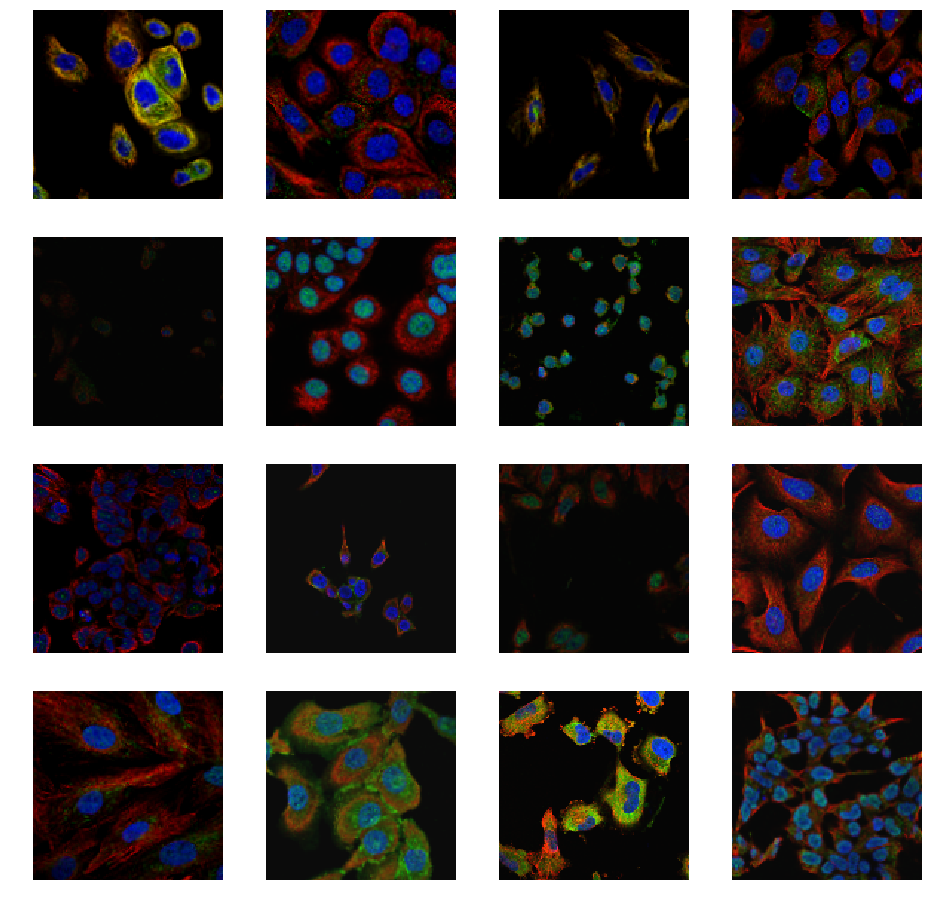

In [21]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(data.trn_ds.denorm(x)))

n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms, cat_separator=" ",
                    suffix='_red.png', val_idxs=val_idxs, test_name='test', num_workers=8)

data = get_data(256)

In [ ]:
#data = data.resize(int(sz*1.3), 'tmp')

class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        #replace first convolutional layer by 4->64 while keeping corresponding weights
        #and initializing new weights with zeros
        w = layers[0].weight
        layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)]
        if p: res.append(nn.Dropout(p=p))
        res.append(nn.Linear(in_features=ni, out_features=nf))
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner1(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        # TODO: Somehow check that directory names haven't changed (e.g. added test set)
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred

sz = 256 #image size
bs = 64  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(f_model, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.crit = FocalLoss()
learner.metrics = [acc]

## Load/Init

In [16]:
sz = 256 #image size
bs = 64  #batch size

data = get_data(sz,bs)
learner = ConvLearner.pretrained(f_model, data, metrics=[acc])
learner.crit = FocalLoss()


In [17]:
#learner.metrics = [acc]

In [18]:
learner

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [19]:
learner.load("2_fit4")

learner.lr_find()

learner.sched.plot()

learner.save("new_rgb_find1")

lr = 3e-1
#learner.fit(lr,1)

learner.fit(lr,1)

learner.save("2_fit1")

In [43]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [44]:
learner.fit(lrs,2,cycle_len=1)
#learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))

epoch      trn_loss   val_loss   acc                        
    0      1.131233   1.120932   0.951025  
    1      1.096163   1.055752   0.952979                   


[1.0557519403817264, 0.9529785301387693]

In [45]:
learner.save("2_fit2")

In [46]:
#learner.freeze()
sz = 256
learner.set_data(get_data(sz, bs=64))

epoch      trn_loss   val_loss   acc                        
    0      1.088369   1.062073   0.952392  


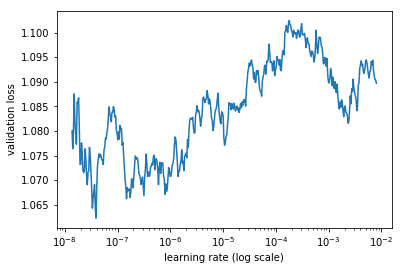

In [49]:
learner.lr_find(start_lr=1e-8, end_lr=1e-2)
learner.sched.plot()

In [50]:
learner.unfreeze()

In [52]:
lr = 1e-6
lrs=np.array([lr/10,lr/4,lr])
learner.fit(lrs,n_cycle=1,cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   acc                        
    0      1.085706   1.065195   0.952588  


[1.0651951240449953, 0.952587831741441]

In [ ]:
learner.sched.plot()

In [53]:
learner.save("2_fit3")

## Polishing some more

 86%|████████▌ | 375/436 [10:03<01:34,  1.55s/it, loss=3.38]

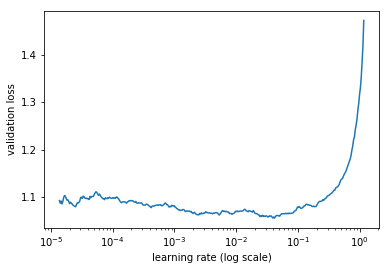

In [72]:
learner.lr_find()
learner.sched.plot()

In [73]:
learner.save("2_find3")

In [79]:
sz = 512
learner.set_data(get_data(sz, bs=64))

In [80]:
learner.freeze()

In [81]:
learner

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [83]:
lr = 1e-6
#lrs=np.array([lr/100,lr/10,lr])
learner.fit(lr,1)

epoch      trn_loss   val_loss   acc                        
    0      1.166945   1.15356    0.949899  


[1.1535599314568126, 0.9498989246066473]

In [85]:
learner.save("2_fit4")

## Submission

In [20]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))
# preds,y = learner.TTA()
# preds = np.stack(preds, axis=-1)
# preds = sigmoid_np(preds)
# pred = preds.max(axis=-1)

In [21]:
preds_t_orig,y_t = learner.TTA(is_test=True)

In [22]:
preds_t = np.stack(preds_t_orig, axis=-1)

In [23]:
preds_t = sigmoid_np(preds_t).max(axis=-1)

In [ ]:
#preds_t = sigmoid_np(preds_t)
#pred_t = preds_t.max(axis=-1)

In [24]:
thresholds_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])

In [25]:
(preds_t > thresholds_t).mean(axis=0).shape

(28,)

In [26]:
pred_list = []
for line in preds_t:
    s = ' '.join(list([str(i) for i in np.nonzero(line>thresholds_t)[0]]))
    if len(s)==0: s = "0"
    pred_list.append(s)

In [27]:
pred_list

['25',
 '0 25',
 '0 1',
 '0 4 5',
 '25',
 '22',
 '0',
 '25',
 '6 11 23',
 '3 4 5',
 '0 4 5',
 '3 4 5',
 '0 25',
 '0',
 '0',
 '0 4',
 '0 25',
 '12 21 25',
 '0',
 '0',
 '0',
 '0',
 '21',
 '21 25',
 '6 25',
 '0 25',
 '0',
 '0',
 '6',
 '25',
 '0 1',
 '3 4 5',
 '0 4',
 '0',
 '12 25',
 '0',
 '25',
 '0 5',
 '3 4',
 '0 25',
 '0',
 '19',
 '0 12 21',
 '0',
 '0 1 3 4 5',
 '0',
 '6 23',
 '6 25',
 '0 12 13 22',
 '6',
 '12 22',
 '0 25',
 '0 25',
 '6 25',
 '0',
 '0 5',
 '6',
 '14 25',
 '25',
 '0',
 '0',
 '0',
 '0 1',
 '0 21',
 '0',
 '19',
 '1 3 4 5',
 '25',
 '0 1 3 4 5',
 '0',
 '0',
 '3 4 5',
 '0 4 5',
 '0',
 '0',
 '25',
 '12 13 22',
 '25',
 '0 4 5',
 '2 3 4',
 '0',
 '0 25',
 '6 25',
 '5 12 22',
 '25',
 '5',
 '0',
 '0 1 4',
 '14',
 '0 25',
 '0 25',
 '0',
 '6 25',
 '0',
 '6',
 '0',
 '0 3 4 5',
 '25',
 '0',
 '6 25',
 '0 25',
 '0',
 '25',
 '0 1 4',
 '0',
 '0 4',
 '0 1 4',
 '6 25',
 '0 1 3 4',
 '25',
 '0 1 4',
 '0',
 '14',
 '3 4 5',
 '3 4 5',
 '0 21 25',
 '0',
 '0 25',
 '0',
 '0 25',
 '0 3 4 5',
 '6 11',

In [28]:
sample_df = pd.read_csv(SAMPLE)
sample_list = list(sample_df.Id)
pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
pred_list_cor = [pred_dic[id] for id in sample_list]
df = pd.DataFrame({'Id':sample_list,'Predicted':0})
df["Predicted"] = pred_list_cor
df
#df.to_csv('protein_classification.csv', header=True, index=False)

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,3 4
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,0 4
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,0 25
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0 4
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,25


In [29]:
message = "resnet34_rgb_4"
pred_file = f"{PATH}protein_classification5.csv"
df.to_csv(pred_file, header=True, index=False)

In [ ]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f {pred_file} -m "{message}"

 75%|█████████████████████████████▉          | 352k/471k [00:00<00:00, 2.99MB/s]

In [ ]:
## Just for filling up time: let's train this some more:

lr = 1e-4
learn.unfreeze()
lrs=np.array([lr,lr/100,lr/100])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)